[울라울라님의 블로그](https://moon-coco.tistory.com/4)를 참고하여 Camera Calibration을 구현하였음.

In [1]:
import cv2 
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
# 사용할 체스판의 가로와 세로 패턴 개수이다.
wc = 9 # 10 - 1 
hc = 6 # 7 - 1 

In [3]:
# object points 행열을 만드는데, wc=9, hc=6인 54x3인 3차원 float type의 행열을 만든다.
# 그리고 np.mgrid 함수를 통해서  (9,6,2) 크기의 격자그리드를 만든 후 Transpose를 취하여 (54, 2) 행열로 
# reshpae하여 준다.
objp = np.zeros((wc * hc, 3), np.float32) # shape -> (54, 3)
objp[:, :2] = np.mgrid[0:wc, 0:hc].T.reshape(-1, 2)

In [4]:
# 위 objp[:, :2]까지 어떻게 되는지를 코드로 나타내보면 
example = np.mgrid[0:wc, 0:hc]
"""
[[[0 0 0 0 0 0]
  [1 1 1 1 1 1]
  [2 2 2 2 2 2]
  [3 3 3 3 3 3]
  [4 4 4 4 4 4]
  [5 5 5 5 5 5]
  [6 6 6 6 6 6]
  [7 7 7 7 7 7]
  [8 8 8 8 8 8]]

 [[0 1 2 3 4 5]
  [0 1 2 3 4 5]
  [0 1 2 3 4 5]
  [0 1 2 3 4 5]
  [0 1 2 3 4 5]
  [0 1 2 3 4 5]
  [0 1 2 3 4 5]
  [0 1 2 3 4 5]
  [0 1 2 3 4 5]]]
"""
print(f"example.T = \n{example.T}, example.T.shape = {example.T.shape}\n\n")
print(f"exmaple.T.reshape(-1, 2) = {example.T.reshape(-1, 2)}, example.T.reshape(-1, 2).shape = {example.T.reshape(-1, 2).shape}")

example.T = 
[[[0 0]
  [1 0]
  [2 0]
  [3 0]
  [4 0]
  [5 0]
  [6 0]
  [7 0]
  [8 0]]

 [[0 1]
  [1 1]
  [2 1]
  [3 1]
  [4 1]
  [5 1]
  [6 1]
  [7 1]
  [8 1]]

 [[0 2]
  [1 2]
  [2 2]
  [3 2]
  [4 2]
  [5 2]
  [6 2]
  [7 2]
  [8 2]]

 [[0 3]
  [1 3]
  [2 3]
  [3 3]
  [4 3]
  [5 3]
  [6 3]
  [7 3]
  [8 3]]

 [[0 4]
  [1 4]
  [2 4]
  [3 4]
  [4 4]
  [5 4]
  [6 4]
  [7 4]
  [8 4]]

 [[0 5]
  [1 5]
  [2 5]
  [3 5]
  [4 5]
  [5 5]
  [6 5]
  [7 5]
  [8 5]]], example.T.shape = (6, 9, 2)


exmaple.T.reshape(-1, 2) = [[0 0]
 [1 0]
 [2 0]
 [3 0]
 [4 0]
 [5 0]
 [6 0]
 [7 0]
 [8 0]
 [0 1]
 [1 1]
 [2 1]
 [3 1]
 [4 1]
 [5 1]
 [6 1]
 [7 1]
 [8 1]
 [0 2]
 [1 2]
 [2 2]
 [3 2]
 [4 2]
 [5 2]
 [6 2]
 [7 2]
 [8 2]
 [0 3]
 [1 3]
 [2 3]
 [3 3]
 [4 3]
 [5 3]
 [6 3]
 [7 3]
 [8 3]
 [0 4]
 [1 4]
 [2 4]
 [3 4]
 [4 4]
 [5 4]
 [6 4]
 [7 4]
 [8 4]
 [0 5]
 [1 5]
 [2 5]
 [3 5]
 [4 5]
 [5 5]
 [6 5]
 [7 5]
 [8 5]], example.T.reshape(-1, 2).shape = (54, 2)


In [5]:
# opencv에서 사용되는 상수라고 하는데 아래 코드의 뜻은 알고리즘이 최대 30회의 반복 또는 0.001의 정확도에 도달하면 
# 종료되도록 설정하는 것을 의미한다고 함
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

objpoints = [] # 체커보드 이미지에 대한 3D 점 벡터를 저장할 벡터 생성
imgpoints = [] # 체커보드 이미지에 대한 2D 점 벡터를 저장할 벡터 생성 

image = cv2.imread('./data/checkerboard.jpeg')
dist = image
origin_image = image
_image = cv2.resize(image, dsize=(640, 480), interpolation=cv2.INTER_AREA)
gray = cv2.cvtColor(_image, cv2.COLOR_BGR2GRAY)

ret, corners = cv2.findChessboardCorners(gray, (wc, hc), None)
# findChessboardCorners 내장 함수 사용 방법 
# - image: 체커보드 사진. 8bit grayscale image 또는 color image 
# - patterSize: 체커보드 행과 열당 내부 코너 수 
# - corners: 감지된 코너의 출력 배열 (생략 가능)
# - flags: 다양한 작업 플레그 
# 반환 값: ret, corners
# - ret: 성공 여부 (bool)
# - corners: 발견된 체스코드 코너의 좌표를 포함하는 Numpy 배열 반환 (N, 1, 2) 형태의 배열 
#       - N: 발견된 코너의 총 수 

In [6]:
images = []

if ret == True: # findChessboardCorners에서 ret이 True라면 
    objpoints.append(objp) 

    corners2 = cv2.cornerSubPix(gray, corners, (10, 10), (-1, -1), criteria) 
    imgpoints.append(corners2)
    # cornerSubPix 
    # - image: 입력 이미지
    # - winSize: 입력 코너의 초기 좌표와 출력을 위해 제공되는 개선 좌표 
    # - zeroZone: 자기상관 행렬의 가능한 특이성을 피하기 위해 때떄로 사용??..
    # - criteria: 코너 미세 조정
    # 반환값: corners 더 정확한(보정된) 코너의 좌표를 반환 
    
    image = cv2.drawChessboardCorners(_image, (wc, hc), corners2, ret)
    # drawChessboardCorners
    # - image: 입력 이미지 
    # - patterSize: 체스판 사이즈 
    # - corners: 코너 좌표 
    # - ret: 성공 여부 

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    # calibrateCamera
    # - objectpoints: 3D 점으로 구성된 벡터 
    # - imgpoints: 2D 이미지 점 벡터 
    # - imageSize: 이미지의 크기 
    #       - gray.shape[::-1]을 하여 (480, 640) 이미지의 크기를 전달
    h, w= image.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1)
    dst = cv2.undistort(image, mtx, dist)
    dst2 = cv2.undistort(image, mtx, dist, None, newcameramtx)
    images = [origin_image, image, dst, dst2]
    titles = ['origin_image', 'image', 'dst', 'dst2']

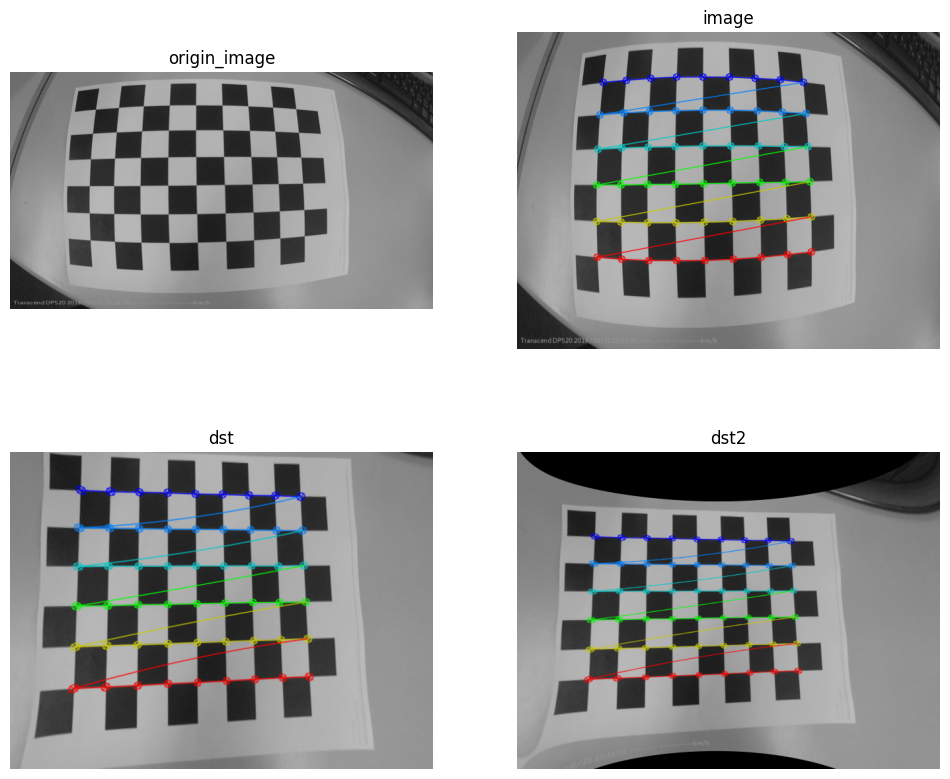

In [7]:
plt.figure(figsize=(12, 10))
for i in range(len(images)):
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.axis('off')
plt.show()